# Imports

In [1]:
!pip install fiftyone

In [12]:
import os
import numpy as np
import transformers
import fiftyone
from PIL import Image
import tensorflow as tf
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except:
        pass

# Data

In [4]:
dataset = fiftyone.zoo.load_zoo_dataset(
        "open-images-v7",
              split="test",
              max_samples=500,
          )

Necessary images already downloaded
Existing download of split 'test' is sufficient
Loading 'open-images-v7' split 'test'
 100% |█████████████████| 500/500 [20.1s elapsed, 0s remaining, 24.1 samples/s]      
Dataset 'open-images-v7-test-500' created


In [5]:
session = fiftyone.launch_app(dataset)

Load and prepare your dataset. It should consist of at least 50k images from any openimages split.

In [6]:
dataset

Name:        open-images-v7-test-500
Media type:  image
Num samples: 500
Persistent:  False
Tags:        []
Sample fields:
    id:              fiftyone.core.fields.ObjectIdField
    filepath:        fiftyone.core.fields.StringField
    tags:            fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:        fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    positive_labels: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classifications)
    negative_labels: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classifications)
    detections:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    points:          fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Keypoints)
    segmentations:   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    relationships:   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.

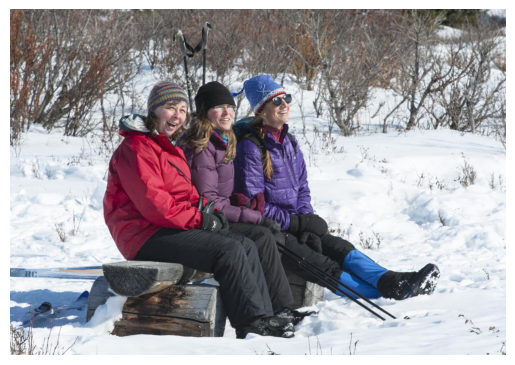

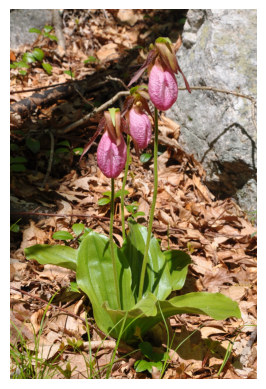

In [20]:
samples = dataset.take(2)

for sample in samples:
    image = Image.open(sample.filepath)
    plt.figure()
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()

In [21]:
# Extract file paths
filepaths = dataset.values("filepath")

# Function to load and preprocess images
def load_and_preprocess_image(filepath):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    # Add any additional preprocessing here (resize, normalize, etc.)
    return image

# Create TensorFlow dataset
tf_dataset = tf.data.Dataset.from_tensor_slices(filepaths)
tf_dataset = tf_dataset.map(load_and_preprocess_image)

Show images from tf_dataset

In [132]:
def show_image(image):
    plt.figure(figsize=(15, 15))
    plt.imshow(image.numpy())
    plt.axis('off')
    plt.show()


# Function to display images in a grid
def show_images(images: list, image_size):
    plt.figure(figsize=(15, 15))

    for i, image in enumerate(images):
        plt.subplot(1, image_size, i + 1)
        plt.imshow(image)
        plt.axis('off')

    plt.show()


# Image augmentation and crops

Implement image augmentation and crops as described in DINO.

In [145]:
class RandomGrayscale(tf.keras.layers.Layer):
    def __init__(self, probability=0.1, **kwargs):
        super(RandomGrayscale, self).__init__(**kwargs)
        self.probability = probability

    def call(self, inputs, training=None, **kwargs):
        random_numbers = tf.random.uniform([], minval=0, maxval=1)
        should_apply_grayscale = random_numbers < self.probability

        def apply_grayscale():
            return tf.image.rgb_to_grayscale(inputs)

        output = tf.cond(should_apply_grayscale, apply_grayscale, lambda: inputs)
        return output

    def get_config(self):
        config = super(RandomGrayscale, self).get_config()
        config.update({'probability': self.probability})
        return config

In [170]:
class DataAugmentationDINO:
    def __init__(self, global_crops_scale, local_crops_scale, local_crops_number):
        self.global_crops_scale = global_crops_scale
        self.local_crops_scale = local_crops_scale
        self.local_crops_number = local_crops_number

        self.flip_and_color_jitter = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomContrast(factor=0.25),
            tf.keras.layers.RandomBrightness(factor=0.3),
            tf.keras.layers.RandomRotation(factor=0.15),
            tf.keras.layers.GaussianNoise(stddev = 0.1),
            RandomGrayscale(probability=0.2),

            tf.keras.layers.Rescaling(scale=1./255)
        ])


    def __call__(self, image):
        global_crop_1 = self._random_resized_crop(image, size=224, scale=self.global_crops_scale)
        global_crop_1 = self.flip_and_color_jitter(global_crop_1)

        global_crop_2 = self._random_resized_crop(image, size=224, scale=self.global_crops_scale)
        global_crop_2 = self.flip_and_color_jitter(global_crop_2)

        local_crops = []
        for _ in range(self.local_crops_number):
            local_crop = self._random_resized_crop(image, size=96, scale=self.local_crops_scale)
            local_crop = self.flip_and_color_jitter(local_crop)
            local_crops.append(local_crop)

        return (global_crop_1, global_crop_2), local_crops

    @staticmethod
    def _random_resized_crop(image, size, scale):
        
        height, width = tf.shape(image)[0].numpy(), tf.shape(image)[1].numpy()
        crop_height = tf.random.uniform(shape=[], minval=tf.cast((height * scale[0]), tf.int32), maxval=tf.cast((height * scale[1]), tf.int32), dtype=tf.dtypes.int32)
        crop_width = tf.random.uniform(shape=[], minval=tf.cast((width * scale[0]), tf.int32), maxval=tf.cast((width * scale[1]), tf.int32), dtype=tf.dtypes.int32)
    
        cropped_image = tf.image.random_crop(image, size=[crop_height, crop_width, 3])
        resized_image = tf.image.resize(cropped_image, [size, size])
    
        return resized_image


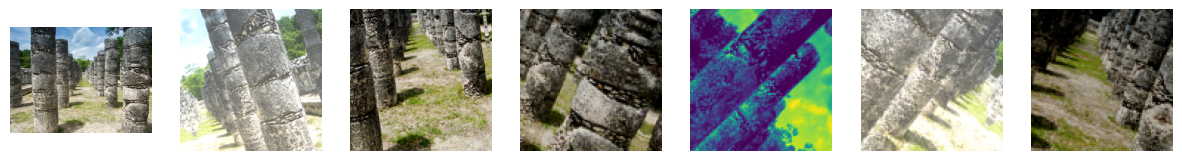

In [171]:
augmentor = DataAugmentationDINO((0.5, 0.6), (0.25, 0.5), 4)
image = next(iter(tf_dataset))
global_crops, local_crops = augmentor(image)
show_images([image] + list(global_crops) + local_crops, 7)

# Losses

Implement the losses and loss additions. DINO, koleo, sinkhorn_knopp, softmax_centering.

In [10]:
def dino_loss(student_output, teacher_output, temperature=0.1):
    """
    DINO loss function.
    student_output: logits from the student network
    teacher_output: logits from the teacher network (detached from gradients)
    temperature: temperature scaling for the softmax function
    """
    student_probs = tf.nn.softmax(student_output / temperature, axis=-1)
    teacher_probs = tf.nn.softmax(teacher_output / temperature, axis=-1)
    loss = tf.reduce_mean(tf.keras.losses.kullback_leibler_divergence(teacher_probs, student_probs))
    return loss

In [11]:
def softmax_centering(logits, center):
    """
    Apply softmax centering.
    logits: logits to be centered
    center: center value to be subtracted from logits
    """
    return tf.nn.softmax(logits - center, axis=-1)

# Backbone

Implement a transformer model as described in DINO, including the DINO head. Don't forget the teacher weights update.

Since we will not be training the backbone, extract features from your dataset.

Run the backbone on the images and save the extracted features. Don't forget to process the images. Images don't have to be of the same size, though it would be faster if they were. If the images don't fit in memory, lazily load them from disk

Split your data (extracted features and labels) into train and test subsets.

Prepare `tf.data.Dataset` or some other way for the data to be used during training.

In [12]:
train_X = tf.data.Dataset.from_tensor_slices(X_train)
train_y = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((train_X, train_y)).batch(128)

test_X = tf.data.Dataset.from_tensor_slices(X_test)
test_y = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip((test_X, test_y)).batch(128)

NameError: name 'X_train' is not defined

# Training

Train the model as described in DINO.

# Evaluation

Show that features extracted by your model are similar for similar images and different for others.

# Bonus

Train a simple classification model on top of your extracted features on some simple dataset.